In [9]:
import re
import gzip
from collections import OrderedDict
import pysam
import matplotlib.pyplot as plt
from matplotlib_venn import *

# Raise error when loading VCF file by Pysam

We load the VCF by pysam module and encounter a fatal error.

In [1]:
last = None
vcf = "data/HG001_GRCh38_1_22_v4.2.1_benchmark_hifiasm_v11_phasetransfer.vcf.gz"
with pysam.VariantFile(vcf) as f:
    for s in f:
        last = s

OSError: unable to parse next record

In [2]:
print(last)

chr6	28509805	.	G	A	50	PASS	platforms=5;platformnames=Illumina,PacBio,CG,10X,Solid;datasets=5;datasetnames=HiSeqPE300x,CCS15kb_20kb,CGnormal,10XChromiumLR,SolidSE75bp;callsets=7;callsetnames=HiSeqPE300xGATK,CCS15kb_20kbDV,CCS15kb_20kbGATK4,CGnormal,HiSeqPE300xfreebayes,10XLRGATK,SolidSE75GATKHC;datasetsmissingcall=IonExome;callable=CS_HiSeqPE300xGATK_callable,CS_CCS15kb_20kbDV_callable,CS_10XLRGATK_callable,CS_CCS15kb_20kbGATK4_callable,CS_CGnormal_callable,CS_HiSeqPE300xfreebayes_callable	GT:DP:ADALL:AD:GQ:IGT:IPS:PS	0|1:822:166,134:218,192:630:0/1:.:PATMAT



The above result indicates that the improper record is behind chr6:28509805. The SNP is near to the MHC region.

# Inspect error records

Next, we inspected the improper records and found that the item count (5) of the FORMAT column is unequal to the item count (7) of the SAMPLE/INTEGRATION column.

Remove the redundant items from SAMPLE will solve the problem.

In [3]:
vcf = "data/HG001_GRCh38_1_22_v4.2.1_benchmark_hifiasm_v11_phasetransfer.vcf.gz"

n = 0
with gzip.open(vcf, "rt") as f:
    for line in f:
        if not line.startswith("#"):
            row = line.strip("\n").split("\t")
            if row[0] == "chr6" and int(row[1]) >= 28509805:
                print(line.strip("\n"))
                n += 1
                if n >= 10:
                    break

chr6	28509805	.	G	A	50	PASS	platforms=5;platformnames=Illumina,PacBio,CG,10X,Solid;datasets=5;datasetnames=HiSeqPE300x,CCS15kb_20kb,CGnormal,10XChromiumLR,SolidSE75bp;callsets=7;callsetnames=HiSeqPE300xGATK,CCS15kb_20kbDV,CCS15kb_20kbGATK4,CGnormal,HiSeqPE300xfreebayes,10XLRGATK,SolidSE75GATKHC;datasetsmissingcall=IonExome;callable=CS_HiSeqPE300xGATK_callable,CS_CCS15kb_20kbDV_callable,CS_10XLRGATK_callable,CS_CCS15kb_20kbGATK4_callable,CS_CGnormal_callable,CS_HiSeqPE300xfreebayes_callable	GT:DP:ADALL:AD:GQ:IGT:IPS:PS	0|1:822:166,134:218,192:630:0/1:.:PATMAT
chr6	28510118	.	T	C	30	.	.	GT:AD:IGT:IPS:PS	0|1:1,1:1|0:.:PATMAT:.:.
chr6	28511949	.	C	CG	30	.	.	GT:AD:IGT:IPS:PS	0|1:1,1:1|0:.:PATMAT:.:.
chr6	28511953	.	C	A	30	.	.	GT:AD:IGT:IPS:PS	0|1:1,1:1|0:.:PATMAT:.:.
chr6	28512023	.	C	T	30	.	.	GT:AD:IGT:IPS:PS	0|1:1,1:1|0:.:PATMAT:.:.
chr6	28512858	.	T	C	30	.	.	GT:AD:IGT:IPS:PS	0|1:1,1:1|0:.:PATMAT:.:.
chr6	28513056	.	T	C	30	.	.	GT:AD:IGT:IPS:PS	0|1:1,1:1|0:.:PATMAT:.:.
chr6	28513257	.	ATAA

# SNPs overlap between v4.2.1 and v3.3.2

v4.2.1 provides more variant calls at autosomal chromosomes.

In [5]:
def load_snps(path):
    snps = list()
    with gzip.open(path, "rt") as f:
        for line in f:
            if line.startswith("#"):
                continue
            row = line.strip("\n").split("\t")
            chrom, position, ref, alt = row[0], row[1], row[3], row[4]
            if re.match("^chr[0-9]+$", chrom) is None:
                continue
            if len(ref) > 1:
                continue
            if len(alt) > 1:
                continue
            snps.append((chrom, position))
    return set(snps)

snps1 = load_snps("data/HG001_GRCh38_GIAB_highconf_CG-IllFB-IllGATKHC-Ion-10X-SOLID_CHROM1-X_v.3.3.2_highconf_PGandRTGphasetransfer.vcf.gz")
snps2 = load_snps("data/HG001_GRCh38_1_22_v4.2.1_benchmark_hifiasm_v11_phasetransfer.vcf.gz")

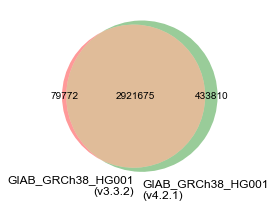

In [7]:
plt.figure(figsize=(4, 3))
venn2([snps1, snps2], set_labels=["GIAB_GRCh38_HG001\n(v3.3.2)", "GIAB_GRCh38_HG001\n(v4.2.1)"])
plt.tight_layout()
plt.show()

# Make SNP/Indel benchmark callset and region

1. The INFO field were set to '.' to save space.
2. The FILTER field were set to 'PASS'.
3. For PATMAT and HOMVAR, the PS tag were set to '0'.
4. The SAMPLE was changed to 'HG001'.
5. Removed redundant FORMAT.

In [12]:
def revise_record(row, lite=False):
    row[6] = "PASS"
    if lite:
        row[7] = "."
    items1 = row[8].split(":")
    items2 = row[9].split(":")
    if len(items1) != len(items2):
        if len(items1) == 5 and len(items2) == 7:
            items2 = items2[:5]
        else:
            assert False
    d = OrderedDict()
    for k, v in zip(items1, items2):
        d[k] = v
    d["IPS"] = d["PS"]
    if d["PS"] == "PATMAT":
        d["PS"] = "0"
    elif d["PS"] == "HOMVAR":
        d["PS"] = "0"
    elif d["PS"] == ".":
        pass
    else: # POS_REF_ALT
        d["PS"] = d["PS"].split("_")[0]
    if lite:
        for k in list(d.keys()):            
            if k not in ["GT", "PS", "IGT", "IPS"]:
                del d[k]
    row[8] = ":".join(d.keys())
    row[9] = ":".join(d.values())
    return row

def make_vcf(vcf1, vcf2, outfile, lite=True):
    # if lite == True: remove redundant information.
    with open(outfile, "w+") as fw:
        for line in gzip.open(vcf1, "rt"):
            if line.startswith("##"):
                if "chrM" in line:
                    continue
                if lite:
                    if line.startswith("##INFO="):
                        continue
                    if line.startswith("##FILTER="):
                        continue
                    if line.startswith("##CL="):
                        continue
                    if line.startswith("##RUN-ID="):
                        continue
                fw.write(line)
            elif line.startswith("#CHROM"):
                row = line.strip("\n").split("\t")
                assert len(row) == 10
                row[-1] = "HG001"
                fw.write("\t".join(row) + "\n")
            else:
                row = line.strip("\n").split("\t")
                fw.write("\t".join(revise_record(row, lite)) + "\n")
        for line in gzip.open(vcf2, "rt"):
            if line.startswith("#"):
                continue
            row = line.strip("\n").split("\t")
            if row[0] == "chrX":
                fw.write("\t".join(revise_record(row, lite)) + "\n")

vcf1 = "data/HG001_GRCh38_1_22_v4.2.1_benchmark_hifiasm_v11_phasetransfer.vcf.gz"
vcf2 = "data/HG001_GRCh38_GIAB_highconf_CG-IllFB-IllGATKHC-Ion-10X-SOLID_CHROM1-X_v.3.3.2_highconf_PGandRTGphasetransfer.vcf.gz"

outfile = "GRCh38_HG001_SNP_Indel.GIAB_v4.2.1_and_v3.3.2.vcf"
make_vcf(vcf1, vcf2, outfile, lite=True)

! bgzip -f GRCh38_HG001_SNP_Indel.GIAB_v4.2.1_and_v3.3.2.vcf
! tabix -f -p vcf GRCh38_HG001_SNP_Indel.GIAB_v4.2.1_and_v3.3.2.vcf.gz

outfile = "GRCh38_HG001_SNP_Indel.GIAB_v4.2.1_and_v3.3.2_full.vcf"
make_vcf(vcf1, vcf2, outfile, lite=False)

! bgzip -f GRCh38_HG001_SNP_Indel.GIAB_v4.2.1_and_v3.3.2_full.vcf
! tabix -f -p vcf GRCh38_HG001_SNP_Indel.GIAB_v4.2.1_and_v3.3.2_full.vcf.gz

In [13]:
with open("GRCh38_HG001_SNP_Indel.GIAB_v4.2.1_and_v3.3.2.bed", "w+") as fw:
    for line in open("data/HG001_GRCh38_1_22_v4.2.1_benchmark.bed"):
        fw.write(line)
    for line in open("data/HG001_GRCh38_GIAB_highconf_CG-IllFB-IllGATKHC-Ion-10X-SOLID_CHROM1-X_v.3.3.2_highconf_nosomaticdel_noCENorHET7.bed"):
        row = line.strip("\n").split("\t")
        if row[0] == "chrX":
            fw.write(line)
            
! bgzip -f -c GRCh38_HG001_SNP_Indel.GIAB_v4.2.1_and_v3.3.2.bed > GRCh38_HG001_SNP_Indel.GIAB_v4.2.1_and_v3.3.2.bed.gz
! tabix -f -p bed GRCh38_HG001_SNP_Indel.GIAB_v4.2.1_and_v3.3.2.bed.gz